In [1]:
from desc.objectives import ObjectiveFunction
from desc.objectives import (
    LCFSBoundaryR,
    LCFSBoundaryZ,
    LambdaGauge,
    LambdaPoincare,
    FixedPressure,
    FixedIota,
    FixedPsi,
    PoincareBoundaryR,
    PoincareBoundaryZ,
)
from desc.objectives import RadialForceBalance, HelicalForceBalance, Energy
from desc.basis import ZernikePolynomial, FourierZernikeBasis,FourierZernike_to_PoincareZernikePolynomial
from desc.transform import Transform
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.plotting import plot_1d,plot_2d,plot_comparison
from desc.optimize import Optimizer
from desc.perturbations import perturb,optimal_perturb
import numpy as np
from desc.geometry import ZernikeRZToroidalSection
%matplotlib inline
from desc.utils import copy_coeffs

DESC version 0.4.13+419.g663f99a.dirty, using JAX backend, jax version=0.2.25, jaxlib version=0.1.76, dtype=float64
Using device: CPU, with 22.89 GB available memory


In [2]:
def get_eq_poin(eq):

    Rlmn = []
    Zlmn = []
    modes_R = []
    modes_Z = []
    
    lm_pairs=[]
    for i,mode in enumerate(eq.R_basis.modes):
        if mode[-1] < 0:
            pass # we do not want the sin(zeta) modes
        else:
            if (mode[0],mode[1]) not in lm_pairs:
                lm_pairs.append((mode[0],mode[1]))
                l=mode[0]
                m=mode[1]
                inds = np.where(np.logical_and(eq.R_basis.modes[:,0] == l,eq.R_basis.modes[:,1] == m ))[0]
                SUM = np.sum(eq.R_lmn[inds])
                Rlmn.append(SUM)
                modes_R.append([l,m])
    lm_pairs=[]
    for i,mode in enumerate(eq.Z_basis.modes):
        if mode[-1] < 0:
            pass # we do not want the sin(zeta) modes
        else:
            if (mode[0],mode[1]) not in lm_pairs:
                lm_pairs.append((mode[0],mode[1]))
                l=mode[0]
                m=mode[1]
                inds = np.where(np.logical_and(eq.Z_basis.modes[:,0] == l,eq.Z_basis.modes[:,1] == m ))[0]
                SUM = np.sum(eq.Z_lmn[inds])
                Zlmn.append(SUM)
                modes_Z.append([l,m])
    
################### get lambda
        # we only need lambda to be constrained at the zeta=0 surface
        # this block here adds up all the L_lm(n>=0) modes
        # so that lambda at the surface can be described with just lm modes
        # and get rid of the toroidal modes
#     target_L_modes = []
#     target_L_lmn = []
#     lm_pairs = []
#     for i, mode in enumerate(eq.L_basis.modes):
#         if mode[-1] < 0:
#             pass  # we do not want the sin(zeta) modes
#         else:
#             if (mode[0], mode[1], 0) not in lm_pairs:
#                 lm_pairs.append((mode[0], mode[1]))
#                 l = mode[0]
#                 m = mode[1]
#                 n = 0
#                 inds = np.where(
#                     np.logical_and(eq.L_basis.modes[:, 0] == l, eq.L_basis.modes[:, 1] == m)
#                 )[0]
#                 SUM = np.sum(eq.L_lmn[inds])
#                 target_L_lmn.append(SUM)
#                 target_L_modes.append([l, m, n])
    
#     target_L_modes = np.asarray(target_L_modes)
#     LZ = np.max(abs(target_L_modes[:, 0]))
#     MZ = np.max(abs(target_L_modes[:, 1]))
#     L_basis = ZernikePolynomial(
#                 L=max(LZ, MZ),
#                 M=max(LZ, MZ),
#                 spectral_indexing='fringe',
#                 sym="sin",
#             )
#     print(target_L_modes == L_basis.modes[:, :2])
#     for i in range(len(target_L_modes)):
#         print(f'{target_L_modes[i,:]} , {L_basis.modes[i, :2]}')
#     L_lmn = copy_coeffs(target_L_lmn, target_L_modes, L_basis.modes[:, :2])
    
    
    surf = ZernikeRZToroidalSection(R_lmn=Rlmn,
                                modes_R=modes_R,
                                Z_lmn=Zlmn,
                                modes_Z=modes_Z,
                               )
    eq_poin = Equilibrium(surface=surf,
                 pressure=eq.pressure,
                 iota=eq.iota,
                 Psi=eq.Psi, # flux (in Webers) within the last closed flux surface
                 NFP=eq.NFP, # number of field periods
                 L=eq.L, # radial spectral resolution
                 M=eq.M, # poloidal spectral resolution
                 N=eq.N, # toroidal spectral resolution 
                 L_grid=eq.L_grid, # real space radial resolution, slightly oversampled
                 M_grid=eq.M_grid, # real space poloidal resolution, slightly oversampled
                 N_grid=eq.N_grid, # real space toroidal resolution
                 sym=True, # explicitly enforce stellarator symmetry
                 bdry_mode='poincare'
                )
    
    
    
    return eq_poin#,L_lmn,L_basis

(<Figure size 864x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

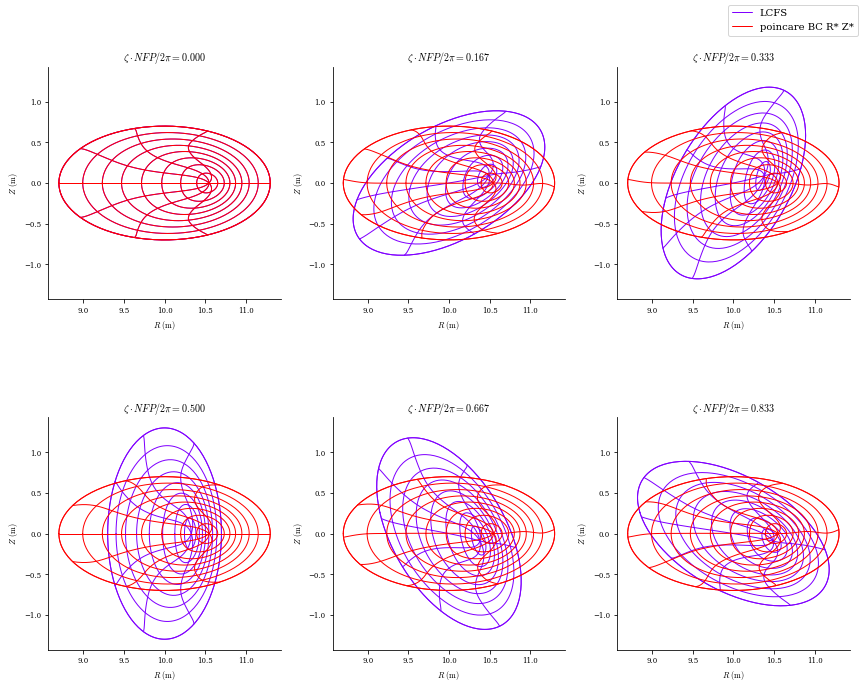

In [3]:
eq = EquilibriaFamily.load(load_from='HELIOTRON/HELIOTRON_output.h5')[-1]
eq_poin = get_eq_poin(eq)
eq_poin.L_lmn = eq.L_lmn
plot_comparison(eqs=[eq,eq_poin],labels=['LCFS','poincare BC R* Z*'])

(<Figure size 288x288 with 2 Axes>,
 <AxesSubplot:title={'center':'$\\lambda~(rad)$'}, xlabel='$\\zeta$', ylabel='$\\theta$'>)

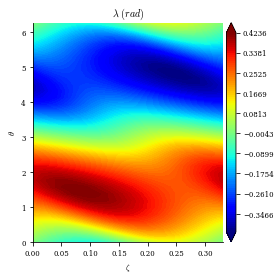

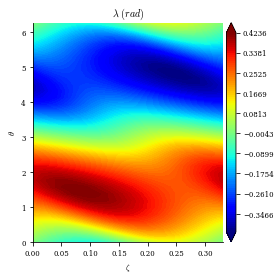

In [4]:
plot_2d(eq=eq,name='lambda')
plot_2d(eq=eq_poin,name='lambda')


In [19]:
constraints = (
    PoincareBoundaryR(),
    PoincareBoundaryZ(),
    LambdaPoincare(),
    LambdaGauge(),
    FixedPressure(),
    FixedIota(),
    FixedPsi(),
)
objectives = (RadialForceBalance(), HelicalForceBalance())
obj = ObjectiveFunction(objectives,constraints)

In [20]:
eq_poin.solve(verbose=3, ftol=1e-2,objective=obj,maxiter=100);

Building constraint: poincare R
Building constraint: poincare Z
Building constraint: lambda poincare
Building constraint: lambda gauge
Building constraint: fixed-pressure
Building constraint: fixed-iota
Building constraint: fixed-Psi
Building objective: radial force
Precomputing transforms
Timer: Precomputing transforms = 400 ms
Building objective: helical force
Precomputing transforms
Timer: Precomputing transforms = 353 ms
Building linear constraints
Timer: linear constraint build = 328 ms
Timer: Objecive build = 1.76 sec
Compiling objective function and derivatives


KeyboardInterrupt: 

In [7]:
#I am pretty sure something is up here
# or that I am starting at too high of res
# should try start lower and use pert

(<Figure size 864x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

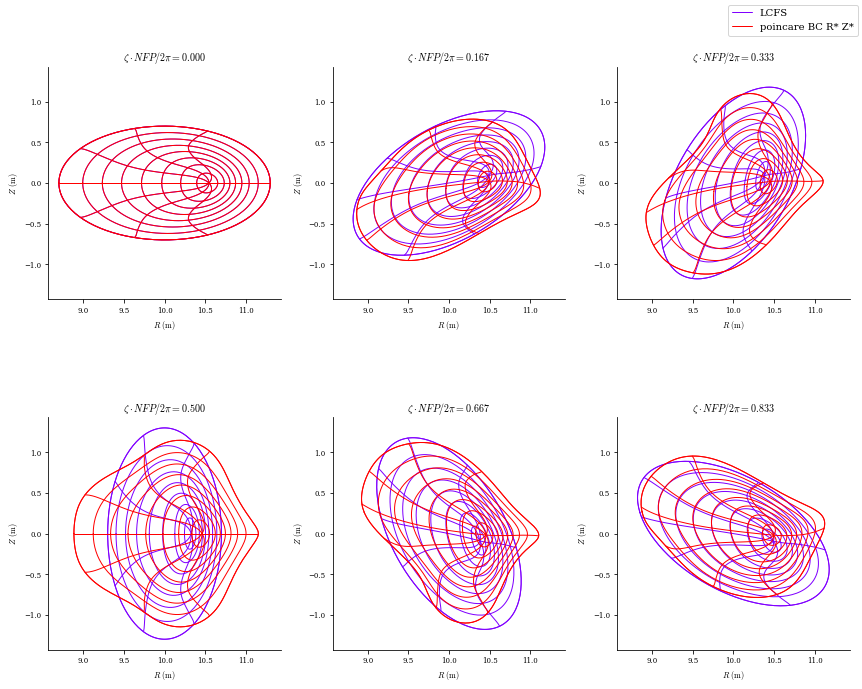

In [8]:
%matplotlib inline
plot_comparison(eqs=[eq,eq_poin],labels=['LCFS','poincare BC R* Z*'])
# this is after solving with Lambda constraint, looks like it is NOT implemented right as vartheta is not correct at zeta=0

(<Figure size 288x288 with 2 Axes>,
 <AxesSubplot:title={'center':'$\\lambda~(rad)$'}, xlabel='$\\theta$', ylabel='$\\rho$'>)

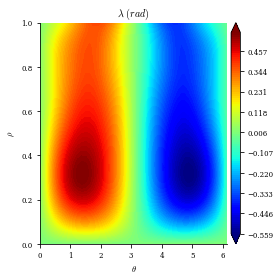

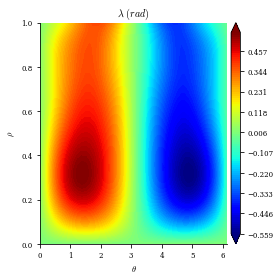

In [9]:
from desc.grid import LinearGrid
plot_2d(eq=eq,name='lambda',grid=LinearGrid(L=50,M=50,zeta=0))
plot_2d(eq=eq_poin,name='lambda',grid=LinearGrid(L=50,M=50,zeta=0))


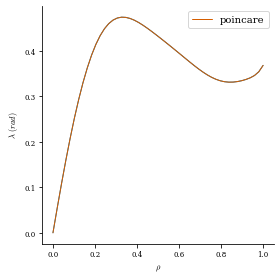

In [10]:
fig,ax = plot_1d(eq=eq,name='lambda',grid=LinearGrid(L=50,theta=2,zeta=0))
fig,ax = plot_1d(eq=eq_poin,name='lambda',grid=LinearGrid(L=50,theta=2,zeta=0),label='poincare',ax=ax)
import matplotlib.pyplot as plt
plt.legend()

In [11]:
# work with a simple SOLOVEV and LOOK AT THE A matrix

In [12]:
# currently does not work with axisymmetry...
# eq = EquilibriaFamily.load(load_from='SOLOVEV/SOLOVEV_simple_output.h5')[-1]
# eq_poin = get_eq_poin(eq)
# eq_poin.L_lmn = eq.L_lmn
# plot_comparison(eqs=[eq,eq_poin],labels=['LCFS','poincare BC R* Z*'])

In [13]:
# constraints = (
#     PoincareBoundaryR(),
#     PoincareBoundaryZ(),
#     LambdaPoincare(),
#     LambdaGauge(),
#     FixedPressure(),
#     FixedIota(),
#     FixedPsi(),
# )
# objectives = (RadialForceBalance(), HelicalForceBalance())
# obj = ObjectiveFunction(objectives,constraints)

In [14]:
# eq_poin.solve(verbose=3, ftol=1e-2,objective=obj,maxiter=2);

In [15]:
# plot_comparison(eqs=[eq,eq_poin],labels=['LCFS','poincare BC R* Z*'])


In [16]:
# test util fxn
eq = EquilibriaFamily.load(load_from='HELIOTRON/HELIOTRON_output.h5')[-1]
L_lmn_2d, L_ZP_zeta0_basis = FourierZernike_to_PoincareZernikePolynomial(eq.L_lmn,eq.L_basis)



In [17]:
from desc.grid import LinearGrid
grid=LinearGrid(L=50,M=50,zeta=0)
transf = Transform(grid=grid,basis=L_ZP_zeta0_basis,derivs=0)

In [18]:
L_2D = transf.transform(L_lmn_2d)